#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim GaussianCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GPInferenceModel, KISS_GPInferenceModel

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2*np.pi*1*x)*1.+0.0

(300, 2)


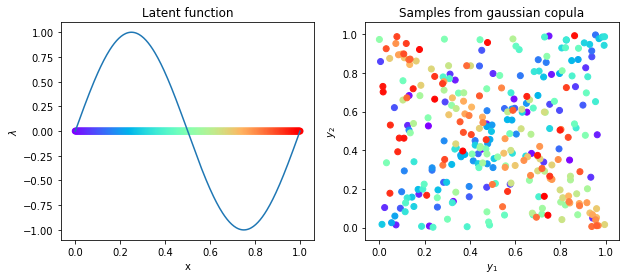

In [3]:
# here we generate some synthetic samples
from starvine.bvcopula.copula.gauss_copula import GaussCopula
import matplotlib.cm as cm

NSamp = 300

X = np.linspace(0,1,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

# Y = np.zeros((NSamp,2))
# copula = GaussCopula()
# for i,x in enumerate(X):
#     if scale(x) == 0:
#         Y[i] = np.random.uniform(low=0,high=1,size=2)
#     else:
#         Y[i] = np.array(copula.sample(1,scale(x))).T # size=1
scales = [scale(x) for x in X]
model = GaussianCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0, 1, NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from gaussian copula')

fig.show()

In [4]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=1)
train_y = torch.tensor(Y).float().cuda(device=1)

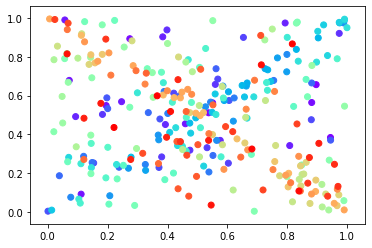

In [5]:
vec_scale = np.vectorize(scale)
scales = vec_scale(X)
m = GaussianCopula(torch.tensor(scales).float())#torch.ones(100)*0.7)
plt.scatter(*m.sample().numpy().T,color=colors)

In [6]:
# define the model (optionally on GPU)
grid_size = 64
#model = GPInferenceModel(train_x, train_y, GaussianCopula_Likelihood())#.cuda(device=0)
model = KISS_GPInferenceModel(GaussianCopula_Likelihood(), grid_size=grid_size).cuda(device=1)

In [7]:
# train the model
from pyro import optim

base_lr = 1e-3
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": .05*(grid_size/128)} #.1 for 256 particles
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": .1}
    else:
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf, means = [], [], []

means.append(model.variational_strategy.variational_distribution.\
             variational_mean.detach().cpu().numpy()) #save initial mean

def train(num_iter=5000):
    elbo = pyro.infer.Trace_ELBO(num_particles=64, vectorize_particles=True, max_plate_nesting=1)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    p = 0.
    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        if not (i + 1) % iter_print:
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}, dLoss: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), mean_p
            ))
            #print(np.std(losses[-100:]))
            if 0 < mean_p < 0.15: 
                print("Converged!")
                break
            p = 0.
            means.append(model.variational_strategy.variational_distribution.\
                         variational_mean.detach().cpu().numpy())
        
%time train()

Basic lr for most of parameters: 0.001
Iter 100/5000 - Loss: 10.1   lengthscale: 0.441, dLoss: 0.0
Iter 200/5000 - Loss: 7.87   lengthscale: 0.409, dLoss: 9.43
Iter 300/5000 - Loss: 2.86   lengthscale: 0.372, dLoss: 2.0
Iter 400/5000 - Loss: 1.0   lengthscale: 0.338, dLoss: 1.38
Iter 500/5000 - Loss: -0.828   lengthscale: 0.311, dLoss: 1.02
Iter 600/5000 - Loss: -2.41   lengthscale: 0.29, dLoss: 0.91
Iter 700/5000 - Loss: -4.27   lengthscale: 0.276, dLoss: 0.702
Iter 800/5000 - Loss: -5.33   lengthscale: 0.266, dLoss: 0.624
Iter 900/5000 - Loss: -6.15   lengthscale: 0.257, dLoss: 0.504
Iter 1000/5000 - Loss: -7.06   lengthscale: 0.251, dLoss: 0.712
Iter 1100/5000 - Loss: -7.45   lengthscale: 0.246, dLoss: 0.429
Iter 1200/5000 - Loss: -8.23   lengthscale: 0.24, dLoss: 0.362
Iter 1300/5000 - Loss: -9.16   lengthscale: 0.236, dLoss: 0.412
Iter 1400/5000 - Loss: -10.1   lengthscale: 0.232, dLoss: 0.232
Iter 1500/5000 - Loss: -10.4   lengthscale: 0.229, dLoss: 0.53
Iter 1600/5000 - Loss: -1

In [15]:
(6*60+28)/2700

0.1437037037037037

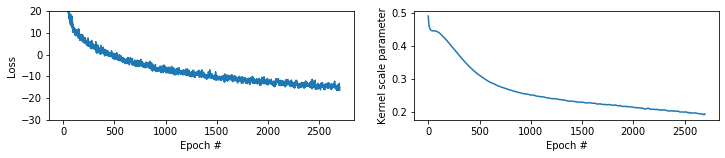

In [11]:
# prot loss function and kernel length
fig, (loss, kern) = plt.subplots(1,2,figsize=(12,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
loss.set_ylim(-30,20)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
fig.show()

In [12]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=1)

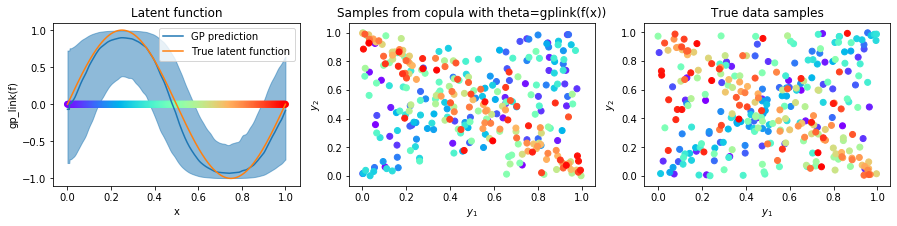

In [13]:
# visualize the result
fig, (func, sim, true) = plt.subplots(1,3,figsize=(15, 3))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
    
F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 1
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula with theta=gplink(f(x))')
true.set_title('True data samples')
# samp.legend()

fig.show()